In [71]:
from keras.preprocessing.image import ImageDataGenerator

In [72]:
datagen = ImageDataGenerator(rescale=1./255)

In [73]:
train_gen = datagen.flow_from_directory('dogscats/train/',
                                        target_size = (150, 150),
                                        batch_size = 128,
                                        shuffle = False,
                                        class_mode='binary'
                                       )

Found 23000 images belonging to 2 classes.


In [74]:
val_gen = datagen.flow_from_directory('dogscats/valid/',
                                      target_size = (150, 150),
                                      batch_size = 128,
                                      shuffle = False,
                                      class_mode='binary'
                                       )

Found 2000 images belonging to 2 classes.


In [75]:
from keras.applications.vgg16 import VGG16

In [76]:
model = VGG16(include_top=False, weights='imagenet', input_shape=(150,150,3))

In [77]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [78]:
# Guardo Training
bottleneck_features_train = model.predict_generator(train_gen, verbose=1)

180/180 [==============================] - 71s 394ms/step


In [79]:
import numpy as np
np.save('bottleneck_features_train.npy', bottleneck_features_train)

In [80]:
bottleneck_features_train.shape

(23000, 4, 4, 512)

In [123]:
bottleneck_features_val = model.predict_generator(val_gen, verbose=1)
np.save('bottleneck_features_val.npy', bottleneck_features_val)

16/16 [==============================] - 6s 382ms/step


In [124]:
bottleneck_features_val.shape

(2000, 4, 4, 512)

In [260]:
from keras.layers import Dense, Input, Flatten, Activation, BatchNormalization, Dropout
from keras.models import Sequential
from keras import regularizers
from keras.constraints import max_norm

In [274]:
model_dense = Sequential()
model_dense.add(Flatten(input_shape=(4,4,512))) 
model_dense.add(BatchNormalization())
model_dense.add(Dropout(0.5))
model_dense.add(Dense(100, kernel_constraint=max_norm(10.)))
model_dense.add(BatchNormalization())
model_dense.add(Activation('relu'))
model_dense.add(Dropout(0.5))
model_dense.add(Dense(1, kernel_constraint=max_norm(10.), activation='sigmoid'))

In [275]:
model_dense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_36 (Flatten)         (None, 8192)              0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 8192)              32768     
_________________________________________________________________
dropout_13 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 100)               819300    
_________________________________________________________________
batch_normalization_22 (Batc (None, 100)               400       
_________________________________________________________________
activation_21 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
__________

In [276]:
from keras.optimizers import Adam
from fnn_helper import PlotLosses

In [277]:
opt = Adam()
model_dense.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

In [278]:
len(train_data)

23000

In [279]:
train_data = np.load('bottleneck_features_train.npy')
train_labels = np.array([0] * int(len(train_data) / 2) + [1] * int(len(train_data) / 2))

validation_data = np.load('bottleneck_features_val.npy')
validation_labels = np.array([0] * int(len(validation_data) / 2) + [1] * int(len(validation_data) / 2))

In [280]:
train_labels, validation_labels

(array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]))

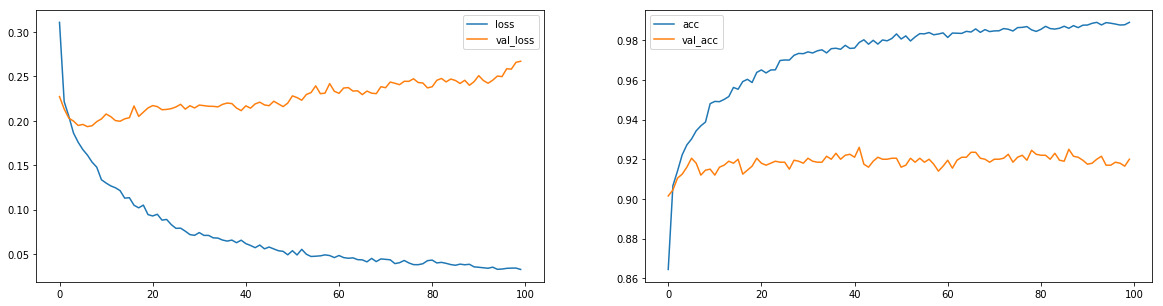

In [281]:
model_dense.fit(train_data, train_labels,
          epochs=100,
          batch_size=256,
          validation_data=(validation_data, validation_labels),
            callbacks=[PlotLosses(1, evaluate_interval=None)])